# SIMEX notebook to demonstrate setting up a Gaussian wavefront using the SimEx Calculator "GaussPhotonSource".

In this notebook, we will demonstrate how to propagate a simple Gaussian wavefront between two planes through vacuum. This is the simplest case of coherent wavefront propagation.

In [1]:
pwd

'/gpfs/exfel/data/user/grotec/Codes/eucall-software/simex_notebooks'

In [5]:
%load_ext autoreload

In [6]:
%autoreload 2

In [7]:
# Import all SimEx modules
from SimEx.Calculators.WavePropagator import WavePropagator
from SimEx.Calculators.GaussianPhotonSource import GaussianPhotonSource
from SimEx.Parameters.WavePropagatorParameters import WavePropagatorParameters
from SimEx.Parameters.GaussWavefrontParameters import GaussWavefrontParameters

from SimEx.Utilities.Units import electronvolt, meter, joule, radian
import numpy

### Setup the initial wavefront
We first create a wavefront with a Gaussian intensity distribution. To this end, we use the `GaussianPhotonSource` Calculator and it's corresponding parameter class, the `GaussWavefrontParameters`. Looking up the documentation of these two classes gives us the information needed to create the instances:

In [4]:
GaussWavefrontParameters?

Init signature:
GaussWavefrontParameters(
    photon_energy=None,
    pulse_energy=None,
    photon_energy_relative_bandwidth=None,
    number_of_transverse_grid_points=None,
    number_of_time_slices=None,
    beam_diameter_fwhm=None,
    divergence=None,
    z=None,
    **kwargs,
)
Docstring:      Abstract class for all calculator parameters.
Init docstring:
:class GaussWavefrontParameters: Encapsulates the parameters of a photon
beam with Gaussian beam profile, Gaussian energy spectrum, and Gaussian
temporal structure.

:param photon_energy: The mean photon energy in units of electronvolts (eV).
:type photon_energy: PhysicalQuantity

:param photon_energy_relative_bandwidth: The relative energy bandwidth
:type photon_energy_relative_bandwidth: float (>0.0).

:param beam_diameter_fwhm: Beam diameter in units of metre (m).
:type beam_diameter_fwhm: PhysicalQuantity

:param pulse_energy: Total energy of the pulse in units of Joule (J).
:type pulse_energy: PhysicalQuantity

:param diverg

In [5]:
GaussianPhotonSource?

Init signature: GaussianPhotonSource(parameters=None, input_path=None, output_path=None)
Docstring:      :class GaussianPhotonSource: Class representing a x-ray free electron laser photon source.
Init docstring:
:param parameters : Photon source parameters.
:type parameters: PhotonBeamParameters

:param output_path: The path where to save output data.
:type output: str, default FELsource_out.h5
File:           /gpfs/exfel/data/user/grotec/Codes/eucall-software/simex_platform/develop/Sources/python/SimEx/Calculators/GaussianPhotonSource.py
Type:           ABCMeta
Subclasses:     


We first describe the wavefront parameters which will then be used to create the wavefront itself:

In [8]:
wavefront_parameters = GaussWavefrontParameters(photon_energy=8.0e3*electronvolt,
                                                photon_energy_relative_bandwidth=1e-3,
                                                beam_diameter_fwhm=1.0e-4*meter,
                                                pulse_energy=2.0e-6*joule,
                                                number_of_transverse_grid_points=400,
                                                number_of_time_slices=12,
                                                z=100*meter,
                                                )

Now, we use these`wavefront_parameters` to initialize the Photon Source.

In [25]:
photon_source = GaussianPhotonSource(wavefront_parameters, input_path="/dev/null", output_path="initial_wavefront.h5")

Let's calculate the initial wavefront and visualize it:

In [26]:
photon_source.backengine()

146.22875114783653


We can retrieve the wavefront data from the calculator:

In [27]:
wavefront = photon_source.data

Let's visualize the wavefront using the WPG utilities.

In [28]:
from wpg import wpg_uti_wf as wpg_utils

First plot the intensity distribution

R-space
(400,) (400,)
FWHM in x = 1.147e-04 m.
FWHM in y = 1.147e-04 m.


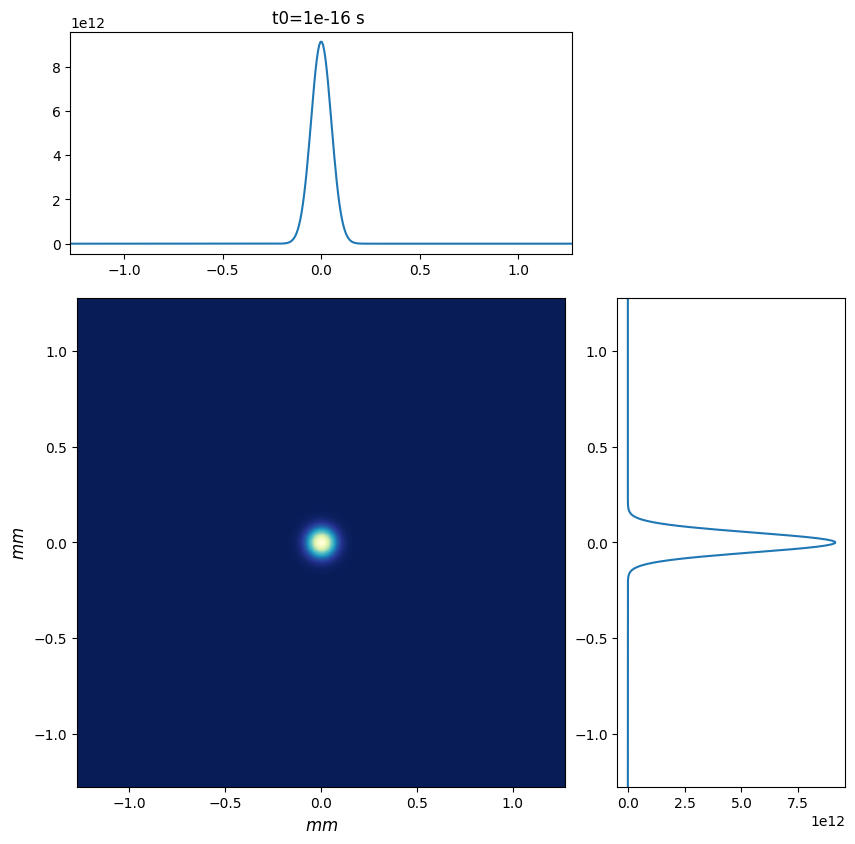

In [56]:
wpg_utils.plot_intensity_map(wavefront)

## Plot intensity distribution in q-space

Q-space
{'fwhm_x': 6.657123479604694e-07, 'fwhm_y': 6.657123479604694e-07}
Q-space
(400,) (400,)


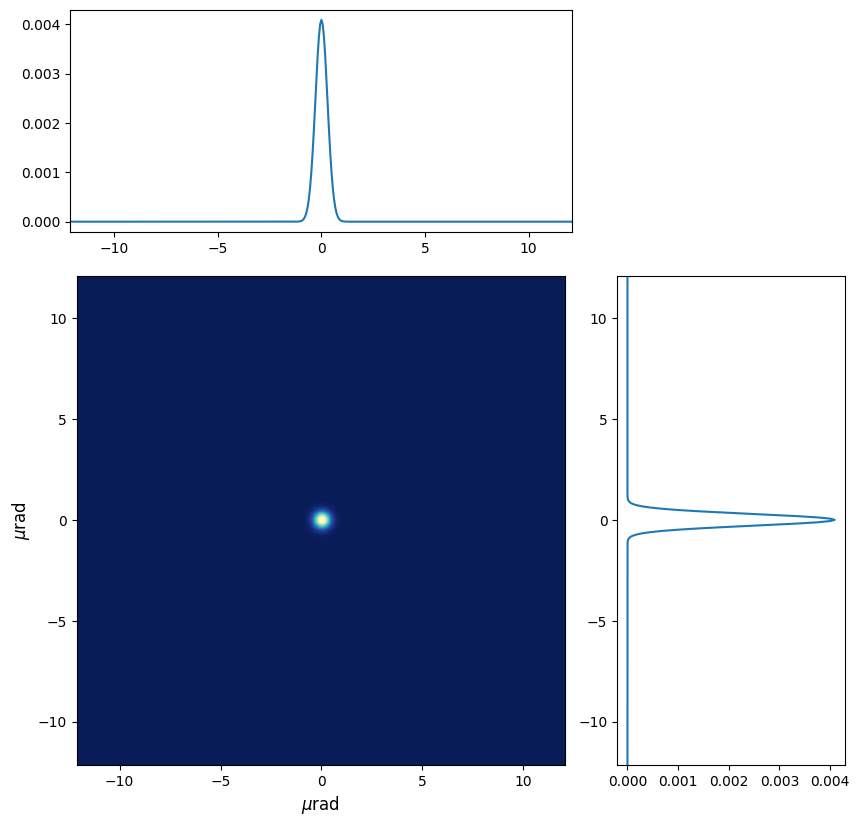

In [12]:
wpg_utils.plot_intensity_qmap(wavefront)

Plot the power as a function of time integrated over the transverse dimensions

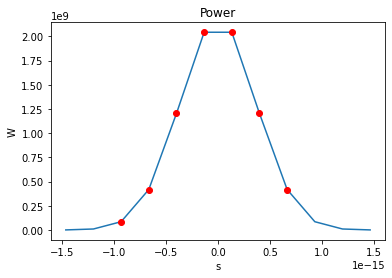

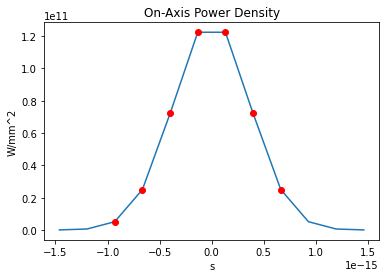

number of meaningful slices: 7
Pulse energy 2e-06 J


1059337216.0

In [13]:

wpg_utils.integral_intensity(wavefront)

Plot the power spectrum

In [29]:
import wpg

Check the sampling quality

In [15]:
print(wpg_utils.check_sampling(wavefront))

WAVEFRONT SAMPLING REPORT
+----------+---------+---------+---------+---------+---------+---------+---------+
|x/y       |FWHM     |px       |ROI      |R        |Fzone    |px*7     |px*10    |
+----------+---------+---------+---------+---------+---------+---------+---------+
|Horizontal|1.147e-04|6.386e-06|2.548e-03|1.772e+02|1.196e-04|4.470e-05|6.386e-05|
|Vertical  |1.147e-04|6.386e-06|2.548e-03|1.772e+02|1.196e-04|4.470e-05|6.386e-05|
+----------+---------+---------+---------+---------+---------+---------+---------+

Horizontal Fresnel zone extension NOT within [7,10]*pixel_width -> Check pixel width."
Vertical Fresnel zone extension NOT within [7,10]*pixel_height -> Check pixel width."
Horizontal ROI > 3* FWHM(x) -> OK
Horizontal ROI > 3* FWHM(y) -> OK
Focus sampling: FWHM > 10*px

END OF REPORT


Ok, we're happy with our initial wavefront and will now proceed to setup the beamline. Our beamline will consist just of a stretch of vacuum over 10 m distance.

## Estimate the beam size after 100 m propagation through empty space
Before we launch the numerical propagation machinery, let's estimate the beam size to be expected after propagating through 10 m of vacuum. 

The beam waist size (rms width of the E-field distribution, or distance from beam axis where intensity drops to $1/e^2$ of its on-axis value) is given by the expression

$ w(z) = w_0 \sqrt{1 + \left(\frac{z}{R}\right)^2}$, with the Rayleigh length $R = \frac{\pi w_0^2}{\lambda}$, $\lambda$ is the central wavelength of the laser (ca,. 0.15 nm at 8 keV.)

Our Gaussian source distribution has a FWHM of $10^{-4} m$. The FWHM and the beam waist radius as defined above are related to each other through $\mathrm{FWHM}(z) = \sqrt{2 \ln 2} w(z) \simeq 1.177 w(z)$


Beam waist at z=0: $w_0 = 100\,\mathrm{\mu m} / 1.177 \simeq 84.9\,\mathrm{\mu m}$.  
The Rayleigh length for our Gaussian beam is $R = \frac{\pi w_0^2}{0.15 \mathrm{nm}} \simeq 151\,\mathrm{m}$.

At $z=100\,\mathrm{m}$, we therefore expect a FWHM of $100\,\mu\mathrm{m}\cdot\sqrt{1.+\left(100/151\right)^2} \simeq 119.9 \mu\mathrm{m}$.

For numerical reasons, we have to set the radius of curvature to a finite value. Here we choose to set it to a value corresponding approximately to a distance of 1 m from the source position, $z = 1\,\mathrm{m}$.

## Setup the beamline

In [30]:
from wpg import Beamline, optical_elements, srwlib


In [31]:
beamline = Beamline()

In [32]:
free_space = optical_elements.Drift(_L=99, _treat=1)

In [33]:
free_space_propagation_parameters = optical_elements.Use_PP(semi_analytical_treatment=1)

In [34]:
beamline.append(free_space, free_space_propagation_parameters)

In [26]:
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 'f')
beamline.propagate(wavefront)
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 't')

R-space
(400,) (400,)
FWHM in x = 1.282e-04 m.
FWHM in y = 1.282e-04 m.


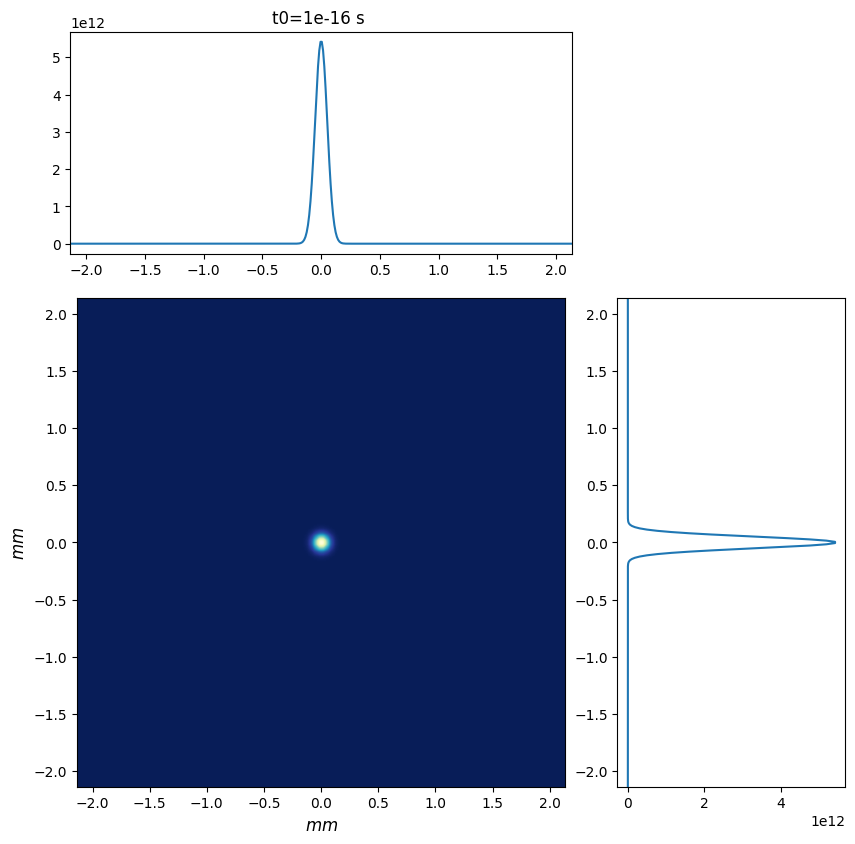

In [21]:
wpg_utils.plot_intensity_map(wavefront)

The result is $\mathrm{FWHM} = 128.2\,\mathrm{\mu m}$ at $z=100\,\mathrm{m}$. Considering that the FWHM is measured by counting pixels in the intensity profile, this is in rather good agreement with the analytical calculation above which yielded $119\,\mathrm{\mu m}$.

## Propagation through a pinhole
We will now put a pinhole aperture into the beam and observe the intensity distribution of our beam behind the aperture.

The aperture is another optical element from `wpg.optical_elements'

In [18]:
from wpg.optical_elements import Aperture

Let's take a look at the documentation

In [28]:
Aperture?

Signature: Aperture(shape, ap_or_ob, Dx, Dy=1e+23, x=0, y=0)
Docstring:
Defining an aperture/obstacle propagator: A wrapper to a SRWL function SRWLOptA()

:param shape:    'r' for rectangular, 'c' for circular
:param ap_or_ob:  'a' for aperture, 'o' for obstacle
:param Dx, Dy:   transverse dimensions [m]; in case of circular aperture, only Dx is used for diameter
:param x, y:     transverse coordinates of center [m]
:return: opAp  - aperture propagator, ``struct SRWLOptA``
File:      ~/Projects/dot.conda/envs/simex/lib/python3.7/wpg/optical_elements.py
Type:      function


In [35]:
pinhole = Aperture(shape='c', 
                   ap_or_ob='a',
                   Dx=50.0e-6,
                   x=0.0,
                   y=0.0,
                   )

In [36]:
pinhole_propagation_parameters = optical_elements.Use_PP(semi_analytical_treatment=0)

In [37]:
beamline.append(pinhole, pinhole_propagation_parameters)

In [23]:
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 'f')
beamline.propagate(wavefront)
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 't')

R-space
(400,) (400,)
FWHM in x = 5.343e-05 m.
FWHM in y = 5.343e-05 m.


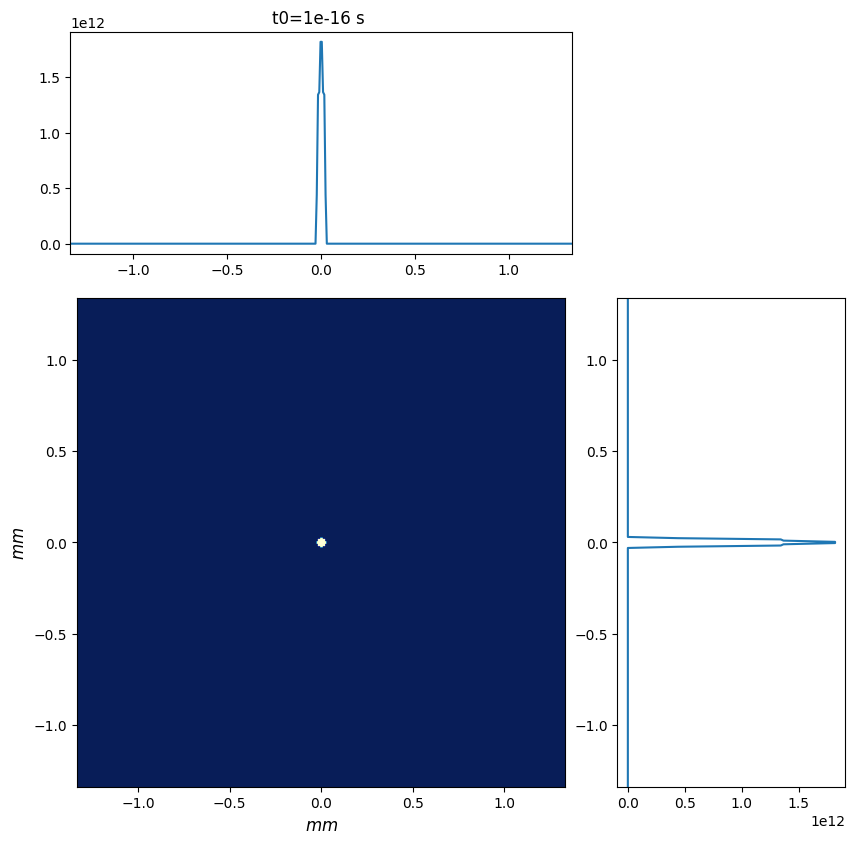

In [24]:
wpg_utils.plot_intensity_map(wavefront)

In [38]:
beamline.append(free_space, free_space_propagation_parameters)

In [39]:
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 'f')
beamline.propagate(wavefront)
srwlib.srwl.SetRepresElecField(wavefront._srwl_wf, 't')

R-space
(400,) (400,)
FWHM in x = 3.211e-04 m.
FWHM in y = 3.211e-04 m.


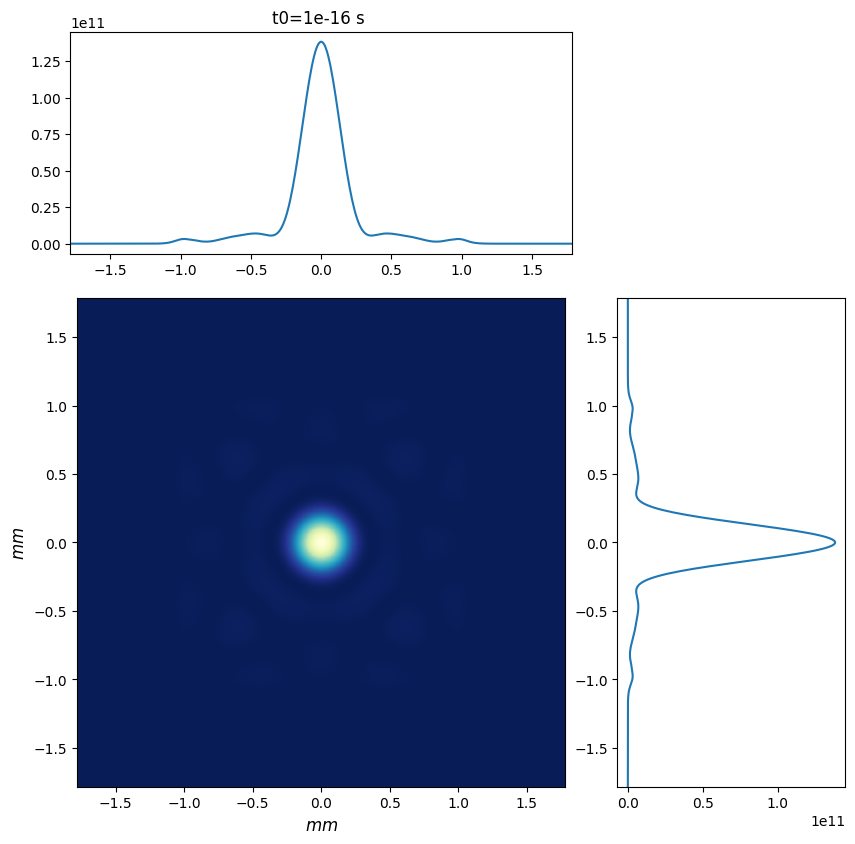

In [40]:
wpg_utils.plot_intensity_map(wavefront)

## Calculate the FWHM of the central diffraction peak and the position of the first diffraction side maximum. Compare your results with the simulated experiment. 
### Pinhole of size 50 $\mu$m.
### Pinhole of size 10 $\mu$m.
### Circular disk of 50 $\mu$m.
### Circular disk of 10 $\mu$m.
### Confirm Babinet's principle. Calculate the ratio of integrated intensities between diffraction from an aperture and from the circular disk.

## Solutions 
